In [1]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install -e ~/Workspace/AI4Finance/FinRL

zsh:1: command not found: apt-get
Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-_3dlt0w3/elegantrl_6b1cb8744bc24b99811064f2feda2b6e
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-_3dlt0w3/elegantrl_6b1cb8744bc24b99811064f2feda2b6e
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl 

In [11]:
!pip install -e ~/Workspace/AI4Finance/FinRL

Obtaining file:///Users/tonyren/Workspace/AI4Finance/FinRL
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ytoad94_/elegantrl_453c864fc877436bb04d9d37299a390b
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/pip-install-ytoad94_/elegantrl_453c864fc877436bb04d9d37299a390b
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit c2939fefe0e3ec55601ded49e39fdf9d7d781ea0
  Preparing metadata (setup.py) ... done
  Building editable for finrl (pyproject.toml) ... done
  Created wheel for finrl: filename=finrl-0.3.6-py3-none-any.whl size=9103 sha256=ebb9a360ce7d0d9eb

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.env_stock_trading.env_stocktrading_stacking import StockTradingStackingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent, DRLStackingAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
import itertools

In [14]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import CUSTOM_TICKER
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2022-11-10'
TEST_START_DATE = '2022-11-11'
TEST_END_DATE = '2024-11-11'

INDICATORS = ['log-ret', 'rsi_30', 'dx_30', 'close_-7_s', 'close_-14_s', 'close_-30_s', 'close_-60_s']

In [15]:
CUSTOM_TICKER = [
    "INTC",
    "F",
    "PARA",
    "LVS"
]

In [16]:
if True:
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = CUSTOM_TICKER).fetch_data()

    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed['log-ret'] = 100*processed['log-ret']
    processed['close_-7_s'] = 100*(processed['close_-7_s'] - processed['close'])/processed['close_-7_s']
    processed['close_-14_s'] =  100*(processed['close_-14_s'] - processed['close'])/processed['close_-14_s']
    processed['close_-30_s'] =  100*(processed['close_-30_s'] - processed['close'])/processed['close_-30_s']
    processed['close_-60_s'] =  100*(processed['close_-60_s'] - processed['close'])/processed['close_-60_s']


    processed.to_csv("datasets/processed.csv", index=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (14956, 8)
Successfully added technical indicators
Successfully added turbulence index


In [17]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension + 5 * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 4, State Space: 57


In [18]:
import random
import copy
def generate_hyperparams_list_from_code(num_variations=5, duplication=4):

    # PPO Variations
    PPO_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3],
        'n_steps': [256, 512, 1024, 2048],
        'batch_size': [64, 128],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3],
        'clip_range': [0.2, 0.3],
        'gae_lambda': [0.95, 0.98]
    }

    # A2C Variations
    A2C_variations = {
        'learning_rate': [1e-5, 1e-4, 1e-3, 0.0007],
        'n_steps': [5, 10, 20],
        'gamma': [0.98, 0.99],
        'ent_coef': [1e-5, 1e-3, 0.005],
        'normalize_advantage': [True, False],
        'use_rms_prop': [True, False]
    }

    # DDPG Variations
    DDPG_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # SAC Variations
    SAC_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'ent_coef': ['auto'],
    }

    # TD3 Variations
    TD3_variations = {
        'learning_rate': [1e-4, 1e-3],
        'batch_size': [64, 128],
        'buffer_size': [int(1e5), int(1e6)],
        'tau': [0.005, 0.01],
        'gamma': [0.98, 0.99],
        'train_freq': [1, 10],
        'action_noise': ['normal', 'ornstein_uhlenbeck']
    }

    # Timesteps Variations
    timesteps_variations = {
        'model_6': [10000]
    }

    hyperparams_list = []
    for i in range(num_variations):
        A2C_kwargs = {k: random.choice(v) for k, v in A2C_variations.items()}
        PPO_kwargs = {k: random.choice(v) for k, v in PPO_variations.items()}
        DDPG_kwargs = {k: random.choice(v) for k, v in DDPG_variations.items()}
        SAC_kwargs = {k: random.choice(v) for k, v in SAC_variations.items()}
        TD3_kwargs = {k: random.choice(v) for k, v in TD3_variations.items()}
        timesteps_dict = {k: random.choice(v) for k, v in timesteps_variations.items()}

        # Assign a unique name to each set
        for j in range(duplication):
            name = f"variant_{j+1}"
            print(name)

            A2C_kwargs['name'] = name
            PPO_kwargs['name'] = name
            DDPG_kwargs['name'] = name
            SAC_kwargs['name'] = name
            TD3_kwargs['name'] = name

            hyperparam = {
                'A2C_model_kwargs': A2C_kwargs,
                'PPO_model_kwargs': PPO_kwargs,
                'DDPG_model_kwargs': DDPG_kwargs,
                'SAC_model_kwargs': SAC_kwargs,
                'TD3_model_kwargs': TD3_kwargs,
                'timesteps_dict': timesteps_dict
            }

            hyperparams_list.append(copy.deepcopy(hyperparam))

    return hyperparams_list

In [19]:
hyperparams_list = generate_hyperparams_list_from_code(num_variations=1, duplication=1)

variant_1


In [9]:
import ray
import random
import numpy as np
import torch

ray.init(ignore_reinit_error=True)

@ray.remote
def run_stacking_with_params(hyperparams, seed, processed):

    rebalance_window = 100
    validation_window = 300
    model_kwargs = hyperparams['A2C_model_kwargs']
    timesteps_dict = hyperparams['timesteps_dict']
    env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

    stacking_agent = DRLStackingAgent(
        df=processed,
        train_period=(TRAIN_START_DATE, TRAIN_END_DATE),
        val_test_period=(TEST_START_DATE, TEST_END_DATE),
        rebalance_window=rebalance_window,
        validation_window=validation_window,
        **env_kwargs
    )

    df_summary = stacking_agent.run_stack_strategy(model_kwargs, timesteps_dict)

    return df_summary

2024-11-29 21:18:14,745	INFO worker.py:1807 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 


In [13]:
ray.shutdown()

In [34]:
seeds = [42]
futures = []

for seed in seeds:
    for hyperparams in hyperparams_list:
        future = run_stacking_with_params.remote(
            hyperparams,
            seed,
            processed
        )
        futures.append(future)

results = ray.get(futures)
for df_summary in results:
    print(df_summary)

RayTaskError(ValueError): [36mray::run_stacking_with_params()[39m (pid=61728, ip=127.0.0.1)
  File "/var/folders/fk/ghrbpzjd2ljb898y6fvw8sgc0000gn/T/ipykernel_61678/808573077.py", line 37, in run_stacking_with_params
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/finrl/agents/stablebaselines3/models.py", line 1004, in run_stack_strategy
    model, sharpe_list, sharpe = self._train_window(
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/finrl/agents/stablebaselines3/models.py", line 835, in _train_window
    model = self.train_model(
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/finrl/agents/stablebaselines3/models.py", line 687, in train_model
    model = model.learn(
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/a2c/a2c.py", line 201, in learn
    return super().learn(
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py", line 287, in learn
    total_timesteps, callback = self._setup_learn(
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/base_class.py", line 423, in _setup_learn
    self._last_obs = self.env.reset()  # type: ignore[assignment]
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/vec_normalize.py", line 295, in reset
    obs = self.venv.reset()
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py", line 78, in reset
    self._save_obs(env_idx, obs)
  File "/Users/tonyren/Workspace/AI4Finance/FinRL/.venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py", line 108, in _save_obs
    self.buf_obs[key][env_idx] = obs
ValueError: could not broadcast input array from shape (49,) into shape (53,)

In [21]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

env_kwargs = {
        "hmax": 1000,
        "initial_amount": 1000000,
        "buy_cost_pct": 0.001,
        "sell_cost_pct": 0.001,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1,
        "print_verbosity":100,
    }

stacking_agent = DRLStackingAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

timesteps_dict = {'model_6' : 10000}

df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)



turbulence_threshold:  32.564943641968675
======Model training from:  2010-01-01 to  2022-11-14
======model_6 Training========
Using cpu device
Logging to tensorboard_log/model_6/model_6_126_12


KeyboardInterrupt: 

In [11]:
df_summary = stacking_agent.run_stack_strategy(A2C_model_kwargs, timesteps_dict)

turbulence_threshold:  102.38746000667793
======Model training from:  2010-01-01 to  2023-11-13
======model_6 Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/model_6/model_6_126_1
-------------------------------------
| time/                 |           |
|    fps                | 24        |
|    iterations         | 100       |
|    time_elapsed       | 20        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -19.9     |
|    explained_variance | -0.0473   |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -33.4     |
|    reward             | 0.9583291 |
|    std                | 1         |
|    value_loss         | 5.98      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 24        |
|    iterations         | 

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [11]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [12]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('stacking',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.294462173125343


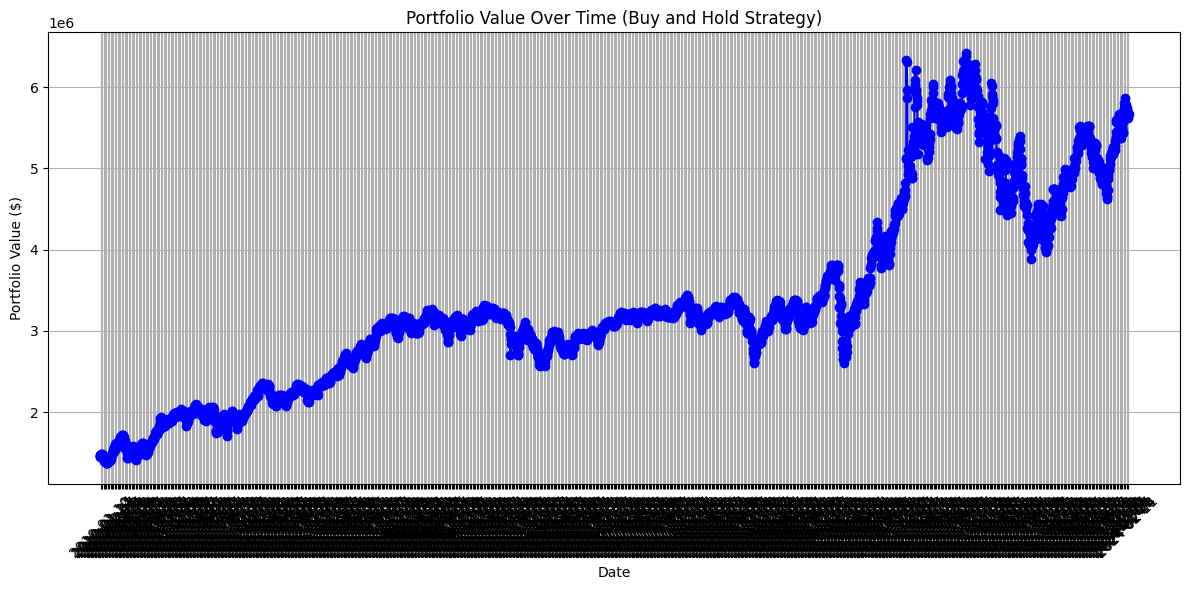

Annual return          0.101868
Cumulative returns     2.926407
Annual volatility      0.234752
Sharpe ratio           0.529938
Calmar ratio           0.257476
Stability              0.846295
Max drawdown          -0.395642
Omega ratio            1.105081
Sortino ratio          0.771668
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936799
Daily value at risk   -0.029082
dtype: float64


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2010-01-04')
end_date = pd.to_datetime('2024-02-14')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



In [18]:
portfolio_data

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence,shares,daily_value
0,2010-01-04,6.447412,7.643214,7.660714,7.622500,493729600,AAPL,0,0.000000,100.000000,66.666667,100.000000,0.000000,389.286075,2967.333081
1,2010-01-04,9.700000,9.700000,9.900000,9.790000,18748700,AMD,0,0.000000,100.000000,66.666667,100.000000,0.000000,399.712214,3913.182560
2,2010-01-04,21.365578,36.000000,36.106667,35.393333,3746700,BEN,0,0.000000,100.000000,66.666667,100.000000,0.000000,2778.272452,98332.323265
3,2010-01-04,6.250716,8.485000,8.565000,8.375000,27146800,CMCSA,0,0.000000,100.000000,66.666667,100.000000,0.000000,1739.382227,14567.326150
4,2010-01-04,16.475374,24.690001,24.840000,24.110001,59853700,CSCO,0,0.000000,100.000000,66.666667,100.000000,0.000000,1455.531725,35092.870768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52341,2024-11-08,50.380001,50.380001,50.750000,50.549999,8699100,LVS,4,0.751904,56.049189,-135.487290,3.759871,7.364255,1328.882151,67174.991734
52342,2024-11-08,11.070000,11.070000,11.540000,11.510000,15682600,PARA,4,0.208019,60.234992,197.948914,59.223310,7.364255,5491.487319,63207.020299
52343,2024-11-08,20.600000,20.600000,20.709999,20.340000,15107800,PCG,4,0.094871,55.607337,80.980163,15.528669,7.364255,4376.115056,89010.180915
52344,2024-11-08,26.360001,26.360001,26.910000,26.860001,1634300,PRGO,4,0.216165,52.333777,129.960548,8.969097,7.364255,2331.019784,62611.192811


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the processed dataframe
portfolio_data = processed.copy()

# Ensure the date column is in datetime format in the copied dataframe
portfolio_data['date'] = pd.to_datetime(portfolio_data['date'])

# Set the initial investment amount
initial_investment = 1_000_000

# Define the start and end dates for the analysis
start_date = pd.to_datetime('2024-02-14')
end_date = pd.to_datetime('2024-08-14')

# Filter the dataframe for the starting date to get initial prices
initial_prices = portfolio_data[portfolio_data['date'] == start_date].copy()

# Calculate the number of shares purchased for each stock
initial_prices['shares'] = initial_investment / len(initial_prices) / initial_prices['open']

# Merge the number of shares into the copied dataframe
portfolio_data = portfolio_data.merge(initial_prices[['tic', 'shares']], on='tic', how='inner')

# Calculate the daily portfolio value
portfolio_data['daily_value'] = portfolio_data['close'] * portfolio_data['shares']
df_account_value_buynhold = portfolio_data.groupby('date')['daily_value'].sum().reset_index()
df_account_value_buynhold.rename(columns={'daily_value': 'account_value'}, inplace=True)

# Filter the data between the start_date and end_date
df_account_value_buynhold['date'] = pd.to_datetime(df_account_value_buynhold['date'])
df_account_value_buynhold = df_account_value_buynhold[
    (df_account_value_buynhold['date'] >= start_date) & (df_account_value_buynhold['date'] <= end_date)
]

# Set the date column as the index
df_account_value_buynhold.set_index('date', inplace=True)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_account_value_buynhold.index, df_account_value_buynhold['account_value'], marker='o', color='b')
plt.title('Portfolio Value Over Time (Buy and Hold Strategy)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value_buynhold.index.min(),
                         end=df_account_value_buynhold.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
df_account_value_buynhold['datadate'] = list(df_account_value_buynhold.index)
df_account_value_buynhold['date'] = list(df_account_value_buynhold.index)
perf_stats_all = backtest_stats(account_value=df_account_value_buynhold)
perf_stats_all = pd.DataFrame(perf_stats_all)



Annual return         -0.081030
Cumulative returns    -0.041371
Annual volatility      0.426482
Sharpe ratio           0.003860
Calmar ratio          -0.314015
Stability              0.018994
Max drawdown          -0.258045
Omega ratio            1.000913
Sortino ratio          0.006452
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.843739
Daily value at risk   -0.053725
dtype: float64


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the date column to datetime format
#df_account_value['date'] = pd.to_datetime(df_account_value['date'])

# Set the date column as the index
#df_account_value.set_index('date', inplace=True)

# Visualization 1: Line plot for account value over time, with weekly xticks
plt.figure(figsize=(12, 6))
plt.plot(df_account_value.index, df_account_value['account_value'], marker='o', color='b')
plt.title('Account Value Over Time')
plt.xlabel('Date')
plt.ylabel('Account Value')

# Set xticks to display weekly intervals
plt.xticks(pd.date_range(start=df_account_value.index.min(), end=df_account_value.index.max(), freq='W'))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
df = pd.read_csv("results/actions_trade_stacking_126.csv")

# Assuming the columns are in the format ['date', '<stock1>', '<stock2>', ...]
dates = df['date']
stocks = df.columns[1:]

# Calculate cumulative sum of shares
cumulative_shares = df[stocks].cumsum()


# Function to get top 5 holdings and collapse the rest into "Other"
def top_5_holdings(cumulative_df):
    top_5_list = []
    for index, row in cumulative_df.iterrows():
        row_values = row.sort_values(ascending=False)
        top_5 = row_values[:5]
        others = row_values[5:].sum()
        top_5['Other'] = others
        top_5_list.append(top_5)
    return pd.DataFrame(top_5_list, index=cumulative_df.index)


# Get top 5 holdings plus 'Other'
top_5_df = top_5_holdings(cumulative_shares)
top_5_df['date'] = dates

# Visualization: Stacked Area Chart
plt.figure(figsize=(14, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(top_5_df.columns[:-1])))
top_5_df.set_index('date').plot(kind='area', stacked=True, color=colors, linewidth=0.5, alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Cumulative Shares')
plt.title('Top 5 Holdings Over Time (Collapsed Others)')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
cumulative_shares

,AAPL,AMD,BEN,CMCSA,CSCO,F,GE,GME,INTC,LVS,PARA,PCG,PRGO,VZ
0,0,0,88,0,52,100,0,100,0,60,83,0,0,0
1,0,0,10,0,152,188,55,173,0,7,110,100,52,0
2,75,0,0,0,107,200,128,273,0,0,210,102,0,0
3,0,0,0,0,101,247,50,279,0,0,308,66,100,0
4,0,0,0,0,152,147,127,379,0,0,408,115,142,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,0,56,0,2592,1091,28,2326,0,146,4057,1210,401,0
58,0,0,0,0,2602,1071,128,2351,0,246,4157,1272,453,17
59,0,0,0,0,2659,1171,97,2323,0,295,4113,1305,506,42
60,19,0,0,100,2729,1187,101,2276,0,268,4213,1329,522,0


<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [18]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.015316
Cumulative returns     0.007629
Annual volatility      0.057614
Sharpe ratio           0.294462
Calmar ratio           0.355505
Stability              0.340524
Max drawdown          -0.043083
Omega ratio            1.063516
Sortino ratio          0.461461
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092186
Daily value at risk   -0.007191
dtype: float64


In [21]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir ./tensorboard_log/

In [25]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (125, 8)
Annual return          0.057152
Cumulative returns     0.027952
Annual volatility      0.114338
Sharpe ratio           0.546898
Calmar ratio           0.971835
Stability              0.224720
Max drawdown          -0.058808
Omega ratio            1.096895
Sortino ratio          0.752622
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912030
Daily value at risk   -0.014157
dtype: float64


In [ ]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [28]:
import scipy as scipy_version_test
scipy_version_test.__version__
scipy_version_test.__numpy_version__


'1.26.4'

In [29]:
import sklearn as sklearn_version_test
sklearn_version_test.__version__


'1.5.2'